In [1]:
# import numpy as np
import glob
import pypianoroll as ppr
import time
import music21
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from utils.utilsPreprocessing import *
#np.set_printoptions(threshold=np.inf)
#torch.set_printoptions(threshold=50000)

In [2]:
##################################
#HYPERPARAMS
##################################
epochs = 1
learning_rate = 1e-3
batch_size= 98
log_interval = 1000  #Log/show loss per batch

# Load MIDI files from npz

In [3]:
data = np.load('/Volumes/EXT/DATASETS/WikifoniaPartlyNoTranspose.npz')

midiDatasetTrain = data['train']
midiDatasetTest = data['test']

data.close()

"""
print("Training set: ({}, {}, {}, {})".format(midiDatasetTrain.size()[0],
                                                midiDatasetTrain.size()[1],
                                                midiDatasetTrain.size()[2],
                                                midiDatasetTrain.size()[3]))
print("Test set: ({}, {}, {}, {})".format(midiDatasetTest.size()[0],
                                                midiDatasetTest.size()[1],
                                                midiDatasetTest.size()[2],
                                                midiDatasetTest.size()[3]))
"""

print("Training set: {}".format(midiDatasetTrain.shape))
print("Test set: {}".format(midiDatasetTest.shape))

Training set: (4056, 1, 96, 60)
Test set: (1034, 1, 96, 60)


In [4]:
fullPitch = 128
_, _, length, reducedPitch = midiDatasetTrain.shape

# CDVAE

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
midiDatasetTrain = torch.from_numpy(midiDatasetTrain)
trainLoader = torch.utils.data.DataLoader(midiDatasetTrain, batch_size=batch_size, shuffle=False, drop_last=True)

midiDatasetTest = torch.from_numpy(midiDatasetTest)
testLoader = torch.utils.data.DataLoader(midiDatasetTest, batch_size=batch_size, shuffle=False, drop_last=True)

In [25]:
class CDVAE(nn.Module):
    def __init__(self, batch_size=7, tie_weights=True):
        super(CDVAE, self).__init__()
        
        self.batch_size = batch_size
        
        ###ENCODER###
        self.encode1 = nn.Sequential(
            nn.Conv2d(1,100,(16,5),stride=(16,5),padding=0),
            nn.BatchNorm2d(100),
            nn.ELU(),
            nn.Conv2d(100,200,(2,1),stride=(2,1),padding=0),
            nn.BatchNorm2d(200),
            nn.ELU(),
            nn.Conv2d(200,400,(2,2),stride=(1,2),padding=0),
            nn.BatchNorm2d(400),
            nn.ELU(),
            nn.Conv2d(400,800,(2,2),stride=(2,2),padding=0),
            nn.BatchNorm2d(800),
            nn.ELU()
        )
            
        self.encode2 = nn.Sequential(
            nn.Linear(2400,800),
            nn.BatchNorm1d(800),
            nn.ELU(),
            nn.Linear(800,400),
            nn.BatchNorm1d(400),
            nn.ELU(),
            nn.Linear(400,100),
            nn.BatchNorm1d(100),
            nn.ELU()
        )

        ###DECODER###
        self.decode1 = nn.Sequential(
            nn.Linear(100,400),
            nn.BatchNorm1d(400),
            nn.ELU(),
            nn.Linear(400,800),
            nn.BatchNorm1d(800),
            nn.ELU(),
            nn.Linear(800,2400),
            nn.BatchNorm1d(2400),
            nn.ELU()
        )
        self.decode2 = nn.Sequential(
            nn.ConvTranspose2d(800,400,(2,2),stride=(2,2),padding=0),
            nn.BatchNorm2d(400),
            nn.ELU(),
            nn.ConvTranspose2d(400,200,(2,2),stride=(1,2),padding=0),
            nn.BatchNorm2d(200),
            nn.ELU(),
            nn.ConvTranspose2d(200,100,(2,1),stride=(2,1),padding=0),
            nn.BatchNorm2d(100),
            nn.ELU(),
            nn.ConvTranspose2d(100,1,(16,5),stride=(16,5),padding=0),
            nn.BatchNorm2d(1),
            nn.ELU()
        )
        
        ###LSTM###
        self.lstm = nn.LSTM(input_size=100, hidden_size=400,
                            num_layers=3, batch_first=True, dropout=0.3)
        self.eluLSTM = nn.ELU()
        self.fc = nn.Linear(400,100)
        self.eluFC = nn.ELU()
    
    def encoder(self, x):
        #print("ENOCDER")
        hEnc = self.encode1(x)
        #print(hEnc.size())
        hEnc = torch.squeeze(hEnc,3).view(-1,800*3)
        #print(hEnc.size())
        hEnc = self.encode2(hEnc)
        return hEnc

    def decoder(self, z):
        #print("DECODER")
        #print(z.size())
        hDec = self.decode1(z)
        hDec = hDec.view(hDec.size()[0],800,-1).unsqueeze(2)
        hDec = self.decode2(hDec)
        return hDec


    def forward(self, x):
        embed = self.encoder(x)
        
        ####MOVE TO HIDDEN_INIT
        h_t = torch.zeros(3,int(embed.size()[0]/7),400).to(device)
        c_t = torch.zeros(3,int(embed.size()[0]/7),400).to(device)        
        ###HIDDEN INIT END
        
        #IF FOR TESTING UNKNOWN SEQUENCES
        if(embed.size()[0]>7):
            embedTemp = torch.chunk(embed, int(self.batch_size/7),dim=0)
            embed7s = embedTemp[0].unsqueeze(0)
            for emb in embedTemp[1:]:
                #print("inloop");print(emb.unsqueeze(1).size())
                embed7s = torch.cat((embed7s, emb.unsqueeze(0)),dim=0)
                #print("afterconcat");print(embed7s.size())
        else:
            embed7s = embed.unsqueeze(0)
            
        lstmOut, (h_t, c_t) = self.lstm(embed7s,(h_t, c_t))
        lstmOut = self.eluLSTM(lstmOut)
        lstmOut = self.fc(lstmOut)
        lstmOut = self.eluFC(lstmOut)
        
        return embed, lstmOut, self.decoder(lstmOut[:,-1,:])

    

model = CDVAE(batch_size=batch_size)
#if(torch.cuda.device_count() > 1):
#    print("Let's use {} GPUs!".format(torch.cuda.device_count()))
#    model = nn.DataParallel(model)

print(model.encode1[0].weight)

model = model.to(device)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.RMSprop(model.parameters(),lr=learning_rate, weight_decay=1e-2)

def loss_function(embed, lstmOut, embedNext):
    
    cosLSTM = nn.CosineSimilarity(dim=0, eps=1e-8)
    
    cosSimLSTM = 0
    #BATCHSIZE 7
    ###WRONG SINCE LOSS CHANGED TO COMPARE EVERY
    ###PREDICTED SEQUENCE WITH THE NEXT
    if(embed.size()[0]==7):
        #print("batchsize = 7 ?")
        cosSimLSTM = cosLSTM(lstmOut.squeeze(1)[-1], embedNext[0])
     
    #BATCHSIZE > 7
    else:
        k=1
        for batchOut in lstmOut:
            for out in batchOut:
                #print(k)
                cosSimLSTM += cosLSTM(out,embed[k])
                k+=1
                if(k==embed.size()[0]-1):
                    break
                    
        cosSimLSTM += cosLSTM(lstmOut[-1,-1,:],embedNext[0])

    return -cosSimLSTM
        

def train(epoch):
    model.train()
    trainLoss = 0

    for batch_idx, data in enumerate(trainLoader):
        #print(batch_idx)
        data = data.float().to(device)
        optimizer.zero_grad()
        embedding, lstmOut, reconPrediction = model(data)
        nextBatch = next(iter(trainLoader)).float().to(device)
        with torch.no_grad():
            embeddingNext, _, _ = model(nextBatch)
        #print(nextBatch.size())
        loss = loss_function(embedding, lstmOut, embeddingNext)
        loss.backward()
        trainLoss += loss.item()
        optimizer.step()
        if(batch_idx % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAccuracy: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainLoader.dataset),
                100. * batch_idx / len(trainLoader),
                -loss.item() / len(data)))
        #if(batch_idx==1):
        #   break
    print('====> Epoch: {} Average accuracy: {:.4f}'.format(
          epoch, -trainLoss / len(trainLoader.dataset)))

def test(epoch):
    model.eval()
    testLoss = 0
    with torch.no_grad():
        for i, data in enumerate(testLoader):
            data = data.float().to(device)
            embedding, lstmOut, reconPrediction = model(data)
            nextBatch = next(iter(testLoader)).float().to(device)
            embeddingNext, _, _= model(nextBatch)
            testLoss += loss_function(embedding, lstmOut, embeddingNext).item()
            
            #if(i==1):
            #    break
    testLoss /= len(testLoader.dataset)

    print('====> Test set accuracy: {:.4f}'.format(-testLoss))

Parameter containing:
tensor([[[[-0.0720, -0.0866,  0.1052, -0.0976, -0.0523],
          [ 0.1003, -0.0650, -0.0859,  0.0602, -0.0944],
          [-0.0327,  0.1035, -0.0756, -0.1069,  0.0066],
          ...,
          [ 0.0764,  0.0114,  0.1064, -0.0287, -0.1115],
          [ 0.0790,  0.0888,  0.0205,  0.0475,  0.0895],
          [-0.1062,  0.0056,  0.0610, -0.0827,  0.0713]]],


        [[[-0.0821,  0.0549,  0.0359,  0.0178, -0.0426],
          [-0.0368, -0.0357,  0.0277,  0.0891,  0.0756],
          [ 0.0970, -0.1073, -0.0757,  0.0799, -0.1013],
          ...,
          [-0.1002,  0.0292,  0.0789,  0.0864,  0.0938],
          [-0.0614, -0.0416, -0.0766,  0.0564,  0.0391],
          [ 0.0479, -0.0400,  0.0428,  0.0479,  0.0987]]],


        [[[ 0.0804, -0.1014, -0.0399, -0.1044, -0.0009],
          [-0.0991,  0.0236,  0.0557,  0.0224, -0.0388],
          [-0.0768, -0.1103,  0.0897,  0.1043,  0.0987],
          ...,
          [ 0.0913,  0.0902,  0.0091,  0.0726, -0.0130],
          [-0

In [8]:

#LOAD MODEL
pathToModel = '../models/WikifoniaNoTranpose_10Epochs_LSTM_noTW_dropout50.model'

try:
    #LOAD TRAINED MODEL INTO GPU
    if(torch.cuda.is_available()):
        model = torch.load(pathToModel)
        
    #LOAD MODEL TRAINED ON GPU INTO CPU
    else:
        model = torch.load(pathToModel, map_location=lambda storage, loc: storage)
    print("\n--------model restored--------\n")
except:
    print("\n--------no saved model found--------\n")

print('')


--------model restored--------




for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

In [9]:
#torch.save(model,'/media/EXTHD/niciData/models/YamahaPianoComp2002_5Epochs_LSTM_noTW.model')

In [10]:
#np.set_printoptions(precision=2, suppress=True, threshold=np.inf)


(1, 96, 60)
(96, 128)
(96, 128)
(96, 128)
(96, 128)
(96, 128)
(96, 128)
(768, 128)
torch.Size([7, 1, 96, 60])
INPUT
(768, 128)


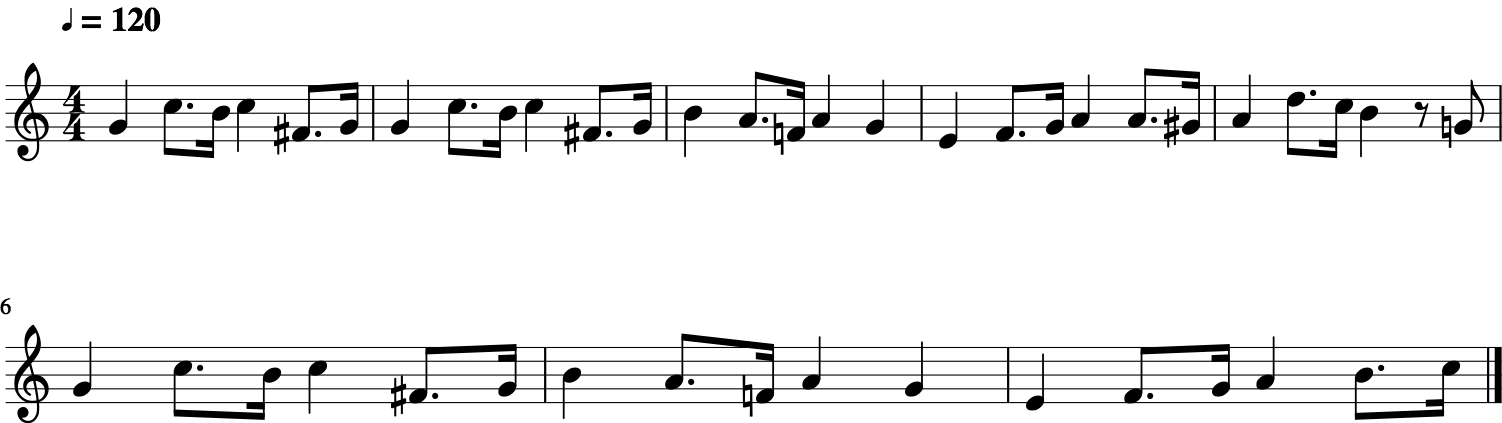

PREDICTION


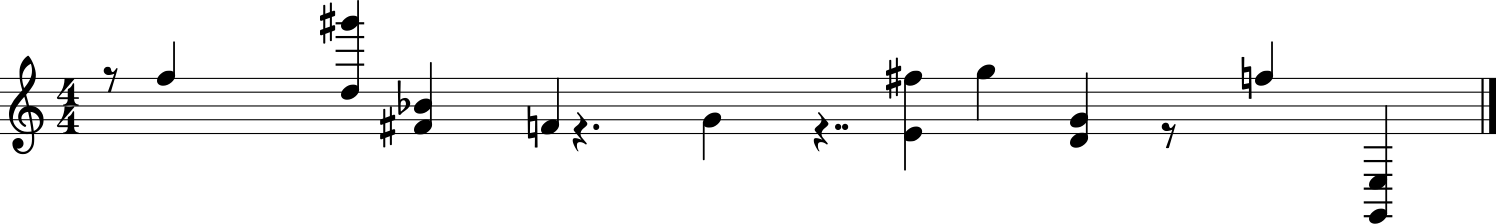

In [21]:

if(model.train()):
    model.eval()

###PREDICT 8th SEQUENCE
with torch.no_grad():
    
    sampleNp1 = getSlicedPianorollMatrixNp("/Volumes/EXT/DATASETS/WikifoniaServer/test/Charlotte-Alington-Pye-Barnard-(1830---1869);-pseudonym-Claribel----Come-back-to-Erin.mid")
    sampleNp1 = deleteZeroMatrices(sampleNp1)
    sample = np.expand_dims(sampleNp1[0,:,36:-32],axis=0)
    print(sample.shape)
    for i, sampleNp in enumerate(sampleNp1[1:7]):
        print(sampleNp.shape)
        if(np.any(sampleNp)):
            sampleNp = sampleNp[:,36:-32]
            sampleNp = np.expand_dims(sampleNp,axis=0)
            sample = np.concatenate((sample,sampleNp),axis=0)
    samplePlay = sample[0,:,:]
    for s in sample:
        samplePlay = np.concatenate((samplePlay,s),axis=0)
    samplePlay = addCuttedOctaves(samplePlay)
    print(samplePlay.shape)
    sample = torch.from_numpy(sample).float().to(device)
    sample = torch.unsqueeze(sample,1)
    print(sample.size())
    _,_, pred = model(sample)
    #reconstruction = recon.squeeze(0).squeeze(0).cpu().numpy()
    prediction = pred.squeeze(0).squeeze(0).cpu().numpy()

    #print(sampleNp[:,:])
    #print(prediction[:,:])
    #print(np.sum(sampleNp.numpy(), axis=1))

    #NORMALIZE PREDICTIONS
    #reconstruction /= np.abs(np.max(reconstruction))
    prediction /= np.abs(np.max(prediction))
    #print(prediction)

    #CHECK MIDI ACTIVATIONS IN PREDICTION TO INCLUDE RESTS
    #reconstruction[reconstruction < 0.3] = 0
    prediction[prediction < 0.6] = 0



    ###MONOPHONIC OUTPUT MATRIX POLOYPHONIC POSSIBLE WITH ACTIVATION THRESHOLD###
    #score = music21.converter.parse('WikifoniaServer/samples/The-Doors---Don\'t-you-love-her-Madly?.mid')
    #score.show()

    samplePlay = debinarizeMidi(samplePlay, prediction=False)
    samplePlay = addCuttedOctaves(samplePlay)
    #reconstruction = debinarizeMidi(reconstruction, prediction=True)
    #reconstruction = addCuttedOctaves(reconstruction)
    prediction = debinarizeMidi(prediction, prediction=True)
    prediction = addCuttedOctaves(prediction)

    #print(np.argmax(samplePlay, axis=1))
    #print('')
    #print(np.argmax(prediction, axis=1))
    print("INPUT")
    print(samplePlay.shape)
    pianorollMatrixToTempMidi(samplePlay)
    tempMidi(show=True,play=True)
    #print("RECONSTRUCTION")
    #pianorollMatrixToTempMidi(reconstruction)        
    #tempMidi(show=True,play=True)
    print("PREDICTION")
    pianorollMatrixToTempMidi(prediction, prediction=True)        
    tempMidi(show=True,play=True)
    print("\n\n")
            

print('')